---

# DS400: Assignment V (Python)

##### Jiazhen Li (Student ID: 6295370)
##### January 27, 2023

---

In [1]:
import numpy as np
import pandas as pd
import requests
import time
import geopandas as gpd

---
### Setting up a new GitHub repository


<div class="alert alert-block alert-info">
    
1. Register on github.com in case you have not done this already.
2. Initialize a new public repository for this assignment on GitHub.
3. For the following exercises of this assignment, follow the standard Git workflow (i.e., pull the latest version of the project to your local computer, then stage, commit, and push all the modifications that you make throughout the project). Every logical programming step should be well documented on GitHub with a meaningful commit message, so that other people (e.g., your course instructor) can follow and understand the development history. You can do this either using Shell commands or a Git GUI of your choice.
4. In the HTML file that you submit, include the hyperlink to the project repository
</div>

#### My repository: https://github.com/jzhenli1/Assignment_5.git

---
### Getting to know the API

<div class="alert alert-block alert-info">
    
5. Visit the documentation website for the API provided by ticketmaster.com. Familiarize yourself with the features and functionalities of the Ticketmaster Discovery API. Have a particular look at rate limits.
6. Whithin the scope of this assignment, you do not have to request your own API key. Instead retrieve a valid key from the API Explorer. This API key enables you to perform the GET requests needed throughout this assignment. Even though this API key is not secret per se (it is publicly visible on the API Explorer website), please comply to the common secrecy practices discussed in the lecture and the tutorial: Treat the API key as a secret token. Your API key should neither appear in the code that you are submitting nor in your public GitHub repository.
</div>

All API keys are issued with a default quota of 5000 API calls per day and rate limitation of 5 requests per second.

In [2]:
# API Key in a separate .py file (part of .gitignore)
with open("Ticketmaster_API_Key.py") as script:
    exec(script.readline())

---
### Interacting with the API - the basics

<div class="alert alert-block alert-info">

7. Perform a first ``GET`` request, that searches for event venues in Germany (``countryCode = "DE"``). Extract
the ``content`` from the ``response`` object and inspect the resulting list. Describe what you can see. 
</div>

In [3]:
APIcontent = requests.get("https://app.ticketmaster.com/discovery/v2/venues/",
                          params = {"apikey": ticketmaster_key,
                                    "countryCode": "DE",
                                    "locale": "*"}).json()
#APIcontent

The content list contains an embedded list of venues, each venue with its own sublist. Each venue list contains several elements (e.g., name, type, url, timezone etc.). Some of these elements stand alone (such as `name` "Grosse Freiheit 36"), while other elements are themselves another list (such as `country` which contains both the `name` "Germany" and the `countrycode` "DE"). At the end of the content list, there is a summary of `totalElements` and `totalPages` which indicates that the request has a total of 12934 elements (aka venues) distributed over 647 pages on the website.

<div class="alert alert-block alert-info">

8. Extract the ``name``, the ``city``, the ``postalCode`` and ``address``, as well as the ``url`` and the ``longitude`` and ``latitude`` of the venues to a data frame.
</div>

In [4]:
# Determining length of each page
length = APIcontent["page"]["size"]

# Creating empty lists of variables with length determined above
Name = [0]*length
City = [0]*length
PostalCode = [0]*length
Address = [0]*length
url = [0]*length
Longitude = [0]*length
Latitude = [0]*length

# Filling each list
for x in range(length):
    Name[x] = APIcontent["_embedded"]["venues"][x]["name"]
    City[x] = APIcontent["_embedded"]["venues"][x]["city"]["name"]
    PostalCode[x] = APIcontent["_embedded"]["venues"][x]["postalCode"]
    Address[x] = APIcontent["_embedded"]["venues"][x]["address"]["line1"]
    url[x] = APIcontent["_embedded"]["venues"][x]["url"]
    Longitude[x] = APIcontent["_embedded"]["venues"][x]["location"]["longitude"]
    Latitude[x] = APIcontent["_embedded"]["venues"][x]["location"]["latitude"]

# Combining all lists together into a dataframe
venues = pd.DataFrame(list(zip(Name, City, PostalCode, Address, url, 
                               Longitude, Latitude)),
                      columns=["Name", "City", "PostalCode", "Address", "url", 
                                                     "Longitude", "Latitude"])

venues.head(10)

,Name,City,PostalCode,Address,url,Longitude,Latitude
0,Grosse Freiheit 36,Hamburg,22767,Grosse Freiheit 36,http://www.ticketmaster.de/venue/287636,9.957905,53.551187
1,Gruenspan,Hamburg,22767,Grosse Freiheit 58,http://www.ticketmaster.de/venue/287155,9.958075,53.551885
2,Huxleys Neue Welt,Berlin,10967,Hasenheide 107 – 113,http://www.ticketmaster.de/venue/286842,13.42138,52.486391
3,Zentrum am Park,Emmelshausen,56281,Rhein-Mosel-Straße 45,https://www.ticketmaster.de/venue/zentrum-am-p...,7.55656,50.15544
4,Stadthalle (Theatersaal),Mülheim,45479,Theodor-Heuss-Platz 1,https://www.ticketmaster.de/venue/stadthalle-t...,6.87471,51.42778
5,Schlossgarten,Bruchsal,76646,Schloss Bruchsal,https://www.ticketmaster.de/venue/schlossgarte...,8.59908,49.12692
6,Stadthalle,Hockenheim,68766,Rathausstraße 3,https://www.ticketmaster.de/venue/stadthalle-h...,8.54908,49.31849
7,FZW,Dortmund,44263,Ritterstraße 20,https://www.ticketmaster.de/venue/fzw-dortmund...,7.4501,51.51481
8,Arena Trier,Trier,54292,Fort-Worth-Platz 1,https://www.ticketmaster.de/venue/arena-trier-...,6.66426,49.77183
9,Eissporthalle,Memmingen,87700,Hühnerbergstraße 19,https://www.ticketmaster.de/venue/eissporthall...,10.16293,47.97999


---
### Interacting with the API - advanced

<div class="alert alert-block alert-info">
    
9. Have a closer look at the list element named page. Did your ``GET`` request from exercise (7) return all event locations in Germany? Obviously not - there are of course much more venues in Germany than those contained in this list. Your ``GET`` request only yielded the first results page containing the first 20 out of several thousands of venues. Check the API documentation under the section Venue Search. How can you request the venues from the remaining results pages? Iterate over the results pages and perform ``GET`` requests for all venues in Germany. After each iteration, extract the seven variables ``name``, ``city``, ``postalCode``, ``address``, ``url``, ``longitude``, and ``latitude``. Join the information in one large data frame. Print the first 10 rows and the shape of the resulting data frame.
</div>

In [5]:
# Creating a function for easier reproducibility of the process
def venues_df(countrycode):
    APIcontent = requests.get("https://app.ticketmaster.com/discovery/v2/venues/",
                              params = {"apikey": ticketmaster_key,
                                        "countryCode": countrycode,
                                        "locale": "*"}).json()
    
    # Determining number of total pages
    pages = APIcontent["page"]["totalPages"]
    # Determining length of each page
    length = APIcontent["page"]["size"]
    
    # Creating empty lists of variables with length determined above
    Name = [0]*length
    City = [0]*length
    PostalCode = [0]*length
    Address = [0]*length
    url = [0]*length
    Longitude = [0]*length
    Latitude = [0]*length
    
    # Creating empty lists to be appended
    NameAll = []
    CityAll = []
    PostalCodeAll = []
    AddressAll = []
    urlAll = []
    LongitudeAll = []
    LatitudeAll = []
    
    # Looping over all pages
    for i in range(pages-1):
        
        # To prevent exceeding rate limit
        time.sleep(.2)
        
        allVenues = requests.get("https://app.ticketmaster.com/discovery/v2/venues/",
                                 params = {"apikey": ticketmaster_key,
                                           "countryCode": countrycode,
                                           "locale": "*",
                                           "page": i}).json()
        
        for x in range(length):
            try:
                Name[x] = allVenues["_embedded"]["venues"][x]["name"]
            except:   # If KeyError occurs ==> set value to nan
                Name[x] = np.nan    
            try:
                City[x] = allVenues["_embedded"]["venues"][x]["city"]["name"]
            except:
                City[x] = np.nan
            try:
                PostalCode[x] = allVenues["_embedded"]["venues"][x]["postalCode"]
            except:
                PostalCode[x] = np.nan
            try:
                Address[x] = allVenues['_embedded']['venues'][x]['address']['line1']
            except:
                Address[x] = np.nan    
            try:
                url[x] = allVenues["_embedded"]["venues"][x]["url"]
            except:
                url[x] = np.nan
            try:
                Longitude[x] = allVenues["_embedded"]["venues"][x]["location"]["longitude"]
            except:
                Longitude[x] = np.nan
            try:
                Latitude[x] = allVenues["_embedded"]["venues"][x]["location"]["latitude"]
            except:
                Latitude[x] = np.nan
    
        # Append lists
        NameAll = NameAll + Name
        CityAll = CityAll + City
        PostalCodeAll = PostalCodeAll + PostalCode
        AddressAll = AddressAll + Address
        urlAll = urlAll + url
        LongitudeAll = LongitudeAll + Longitude
        LatitudeAll = LatitudeAll + Latitude
        
    # For the last page which is usually not filled
    # Number of venues remaining (using modulo operator)
    length = APIcontent['page']['totalElements'] % length

    # Create set of new empty lists with the remaining length
    Name = [0]*length
    City = [0]*length
    PostalCode = [0]*length
    Address = [0]*length
    url = [0]*length
    Longitude = [0]*length
    Latitude = [0]*length

    i = i+1
    
    allVenues = requests.get("https://app.ticketmaster.com/discovery/v2/venues/",
                              params = {"apikey": ticketmaster_key,
                                        "countryCode": "DE",
                                        "locale": "*",
                                        "page": i}).json()
    
    for x in range(length):
        try:
            Name[x] = allVenues["_embedded"]["venues"][x]["name"]
        except:
            Name[x] = np.nan    
        try:
            City[x] = allVenues["_embedded"]["venues"][x]["city"]["name"]
        except:
            City[x] = np.nan
        try:
            PostalCode[x] = allVenues["_embedded"]["venues"][x]["postalCode"]
        except:
            PostalCode[x] = np.nan
        try:
            Address[x] = allVenues['_embedded']['venues'][x]['address']['line1']
        except:
            Address[x] = np.nan    
        try:
            url[x] = allVenues["_embedded"]["venues"][x]["url"]
        except:
            url[x] = np.nan
        try:
            Longitude[x] = allVenues["_embedded"]["venues"][x]["location"]["longitude"]
        except:
            Longitude[x] = np.nan
        try:
            Latitude[x] = allVenues["_embedded"]["venues"][x]["location"]["latitude"]
        except:
            Latitude[x] = np.nan
    
    # Append lists
    NameAll = NameAll + Name
    CityAll = CityAll + City
    PostalCodeAll = PostalCodeAll + PostalCode
    AddressAll = AddressAll + Address
    urlAll = urlAll + url
    LongitudeAll = LongitudeAll + Longitude
    LatitudeAll = LatitudeAll + Latitude
    
    # Combining all lists into a dataframe
    df = pd.DataFrame(list(zip(NameAll, CityAll, PostalCodeAll, AddressAll, urlAll,
                               LongitudeAll, LatitudeAll)),
                      columns=["Name", "City", "PostalCode", "Address", "url",
                               "Longitude", "Latitude"])
    
    # Converting longtitude and latitude to numeric for visualization later
    df["Longitude"] = pd.to_numeric(df["Longitude"])
    df["Latitude"] = pd.to_numeric(df["Latitude"])
    
    # Return the final dataframe
    return df

In [6]:
# Call the function
venues_DE = venues_df("DE")
venues_DE.shape

(12933, 7)

In [7]:
venues_DE.head(10)

,Name,City,PostalCode,Address,url,Longitude,Latitude
0,Grosse Freiheit 36,Hamburg,22767,Grosse Freiheit 36,http://www.ticketmaster.de/venue/287636,9.957905,53.551187
1,Gruenspan,Hamburg,22767,Grosse Freiheit 58,http://www.ticketmaster.de/venue/287155,9.958075,53.551885
2,Huxleys Neue Welt,Berlin,10967,Hasenheide 107 – 113,http://www.ticketmaster.de/venue/286842,13.421380,52.486391
3,Zentrum am Park,Emmelshausen,56281,Rhein-Mosel-Straße 45,https://www.ticketmaster.de/venue/zentrum-am-p...,7.556560,50.155440
4,Stadthalle (Theatersaal),Mülheim,45479,Theodor-Heuss-Platz 1,https://www.ticketmaster.de/venue/stadthalle-t...,6.874710,51.427780
5,Schlossgarten,Bruchsal,76646,Schloss Bruchsal,https://www.ticketmaster.de/venue/schlossgarte...,8.599080,49.126920
6,Stadthalle,Hockenheim,68766,Rathausstraße 3,https://www.ticketmaster.de/venue/stadthalle-h...,8.549080,49.318490
7,FZW,Dortmund,44263,Ritterstraße 20,https://www.ticketmaster.de/venue/fzw-dortmund...,7.450100,51.514810
8,Arena Trier,Trier,54292,Fort-Worth-Platz 1,https://www.ticketmaster.de/venue/arena-trier-...,6.664260,49.771830
9,Eissporthalle,Memmingen,87700,Hühnerbergstraße 19,https://www.ticketmaster.de/venue/eissporthall...,10.162930,47.979990


---
### Visualizing the extracted data

<div class="alert alert-block alert-info">
    
10. Add points to the map indicating the locations of the event venues across Germany.
</div>

<AxesSubplot:>

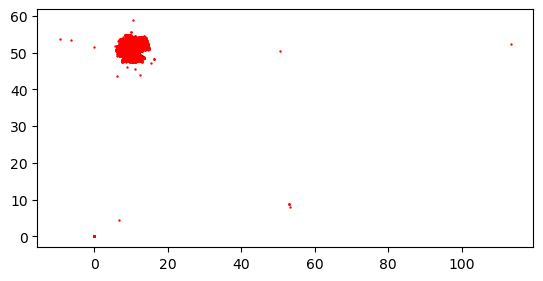

In [8]:
%%capture --no-display

# Get coordinates
coord = gpd.GeoDataFrame(
    venues_DE, geometry=gpd.points_from_xy(venues_DE.Longitude, venues_DE.Latitude))

# Get a base map of Germany
map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ax = map[map.name == "Germany"].plot(color='white', edgecolor='black')

# Plot the map
coord.plot(ax=ax, color='red', markersize=0.5)

<div class="alert alert-block alert-info">
    
11. You will find that some coordinates lie way beyond the German borders and can be assumed to be faulty. Set coordinate values to NA where the value of ``longitude`` is outside the range (``5.866``, ``15.042``) or where the value of latitude is outside the range (``47.270``, ``55.059``)
</div>

<AxesSubplot:>

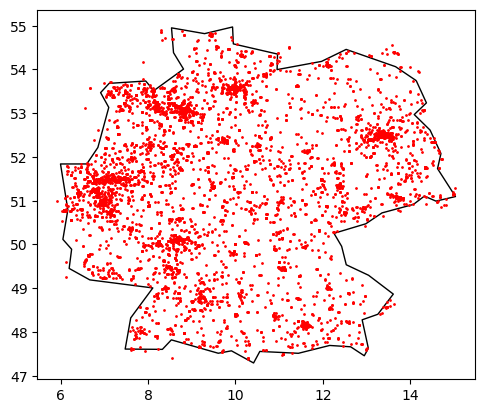

In [9]:
%%capture --no-display

venues_DE['Longitude'] = np.where((venues_DE['Longitude'] < 5.866) |
                                  (venues_DE['Longitude'] > 15.042),
                                  np.nan, venues_DE['Longitude'])

venues_DE['Latitude'] = np.where((venues_DE['Latitude'] < 47.270) |
                                 (venues_DE['Latitude'] > 55.059),
                                 np.nan, venues_DE['Latitude'])

coord = gpd.GeoDataFrame(
    venues_DE, geometry=gpd.points_from_xy(venues_DE.Longitude, venues_DE.Latitude))

map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ax = map[map.name == "Germany"].plot(color='white', edgecolor='black')

coord.plot(ax=ax, color='red', markersize=1)

---
### Event locations in other countries

<div class="alert alert-block alert-info">

12. Repeat exercises (9)–(11) for another European country of your choice.
</div>

In [10]:
# Country: Switzerland, code: "CH"
venues_CH = venues_df("CH")
venues_CH.shape

(425, 7)

In [11]:
venues_CH.head(10)

,Name,City,PostalCode,Address,url,Longitude,Latitude
0,Salle de l'Alhambra,Genève,1204,Rue de la Rôtisserie 10,https://www.ticketmaster.ch/venue/salle-de-lal...,6.14652,46.20272
1,Kulturfabrik KUFA Lyss,Lyss,3250,Werdtstrasse 17,https://www.ticketmaster.ch/venue/kulturfabrik...,7.29471,47.08075
2,Klostersaal Stans,Stans,6370,Mürgstrasse 18,https://www.ticketmaster.ch/venue/klostersaal-...,8.36912,46.95569
3,ILFISHALLE Langnau,Langnau im Emmental,3550,Güterstrasse 14,https://www.ticketmaster.ch/venue/ilfishalle-l...,7.78612,46.93628
4,Stadion Letzigrund,Zürich,8048,Badenerstrasse 500,https://www.ticketmaster.ch/venue/stadion-letz...,8.50377,47.38265
5,St Jakobshalle,Basel,4052,St. Jakobs-Strasse 390,https://www.ticketmaster.ch/venue/st-jakobshal...,7.61821,47.54040
6,Moods,Zürich,8005,Schiffbaustrasse 6,https://www.ticketmaster.ch/venue/moods-zurich...,8.51817,47.38994
7,AXA ARENA,Winterthur,8400,Grüzefeldstrasse 36,https://www.ticketmaster.ch/venue/axa-arena-wi...,8.74983,47.49438
8,Konzertfabrik Z7,Pratteln,4133,Kraftwerkstrasse 7,https://www.ticketmaster.ch/venue/konzertfabri...,7.69409,47.52748
9,Plaza,Zürich,8004,Badenerstrasse 109,https://www.ticketmaster.ch/venue/plaza-zurich...,8.52476,47.37419


<AxesSubplot:>

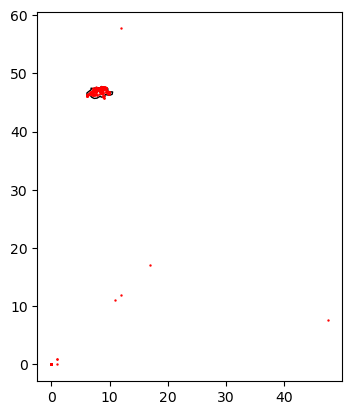

In [12]:
%%capture --no-display

coord = gpd.GeoDataFrame(
    venues_CH, geometry=gpd.points_from_xy(venues_CH.Longitude, venues_CH.Latitude))

map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ax = map[map.name == "Switzerland"].plot(color='white', edgecolor='black')

coord.plot(ax=ax, color='red', markersize=0.5)

<AxesSubplot:>

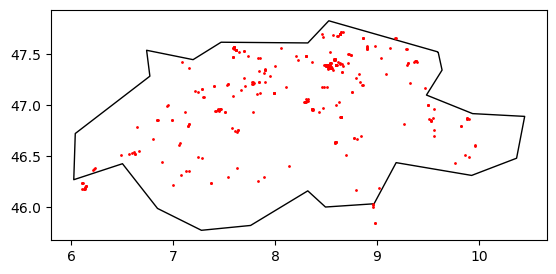

In [13]:
%%capture --no-display

venues_CH['Longitude'] = np.where((venues_CH['Longitude'] < 5.956) |
                                  (venues_CH['Longitude'] > 10.492),
                                  np.nan, venues_CH['Longitude'])

venues_CH['Latitude'] = np.where((venues_CH['Latitude'] < 45.818) |
                                 (venues_CH['Latitude'] > 47.808),
                                 np.nan, venues_CH['Latitude'])

coord = gpd.GeoDataFrame(
    venues_CH, geometry=gpd.points_from_xy(venues_CH.Longitude, venues_CH.Latitude))

map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ax = map[map.name == "Switzerland"].plot(color='white', edgecolor='black')

coord.plot(ax=ax, color='red', markersize=1)